# Recurrent Neural Networks (RNNs) and Gated Recurrent Units (GRUs)

This notebook will demonstrate the usage of RNNs and GRUs for the prediction of protein secondary structure with the help of input amino acid sequences

## Step 1: Setting up and importing required libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torch.utils.data import DataLoader,Dataset
from torch.nn.utils.rnn import pack_padded_sequence,pad_packed_sequence

import numpy as np
import pandas as pd
import random
import os
import pickle
import time
import tqdm

from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

import seaborn as sns

from matplotlib import pyplot as plt

random.seed(42)
torch.manual_seed(42)
np.random.seed(42)

## Step 2: Load the dataset and preprocess data


Here, we define a function to load a pickle file, which is called when a `Dataset` class is instantiated. This class also provides access to public functions `__len__` and `__getitem__` which can help access attributes of the dataset. These methods are also required by PyTorch Dataset.

In [165]:
def load_from_pkl(path):
    with open(path, 'rb') as f:
        var = pickle.load(f)
    return var

# class to index loaded dataset
class Dataset(Dataset):
    def __init__(self, path_to_pkl):
        self.data = load_from_pkl(path_to_pkl)
        self.ids = list(self.data.keys())

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        id = self.ids[index]
        dict = self.data[id]
        seq = dict["sequence"]
        pssm = dict["pssm"]
        length = len(seq)
        secstr_q3 = dict["secstr_q3"]
        secstr = dict["secstr"]

        return id, seq, pssm, length, secstr, secstr_q3
    
train = Dataset('../../datasets/protein-secondary-structure-train.pkl')
val = Dataset('../../datasets/protein-secondary-structure-val.pkl')
test = Dataset('../../datasets/protein-secondary-structure-test.pkl')

### Data Exploration, before preprocessing

Convert the dataset into a pandas dataframe. Extract sequences, secondary structure labels and sequence lengths. Find the maximum sequence length for padding purposes.

In [166]:
training_data = {
    "Sequence": [],
    "Secondary Structure": [],
    "Length": []
}

for i in range(train.__len__()):
    id, seq, pssm, length, secstr8, secstr = train[i]
    training_data["Sequence"].append(seq)
    training_data["Secondary Structure"].append(secstr)
    training_data["Length"].append(length)

train_df = pd.DataFrame(training_data)
print(train_df.head())
max_sequence_length = train_df['Length'].max()

print(f'Max sequence length in training data: {max_sequence_length}')

                                            Sequence  \
0  [10, 2, 1, 7, 11, 12, 12, 14, 14, 12, 16, 13, ...   
1  [5, 3, 19, 12, 16, 18, 19, 5, 0, 11, 12, 19, 4...   
2  [15, 13, 2, 14, 2, 10, 6, 15, 12, 14, 17, 15, ...   
3  [9, 8, 6, 0, 6, 10, 4, 0, 4, 1, 19, 15, 16, 7,...   
4  [15, 15, 16, 18, 13, 15, 4, 16, 10, 15, 8, 6, ...   

                                 Secondary Structure  Length  
0  [2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, ...      62  
1  [2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, ...     315  
2  [2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...     148  
3  [2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 0, 0, ...     344  
4  [2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...      75  
Max sequence length in training data: 696


Visualizing secondary structure distribution in training data.

Here the target labels stand for the following:
- *H* : $\alpha$-helix, $3$-helix, $\pi$-helix
- *E* : $\beta$-strand, $\beta$-bridge
- *C* : Loops and irregular elements, Turn, Bend

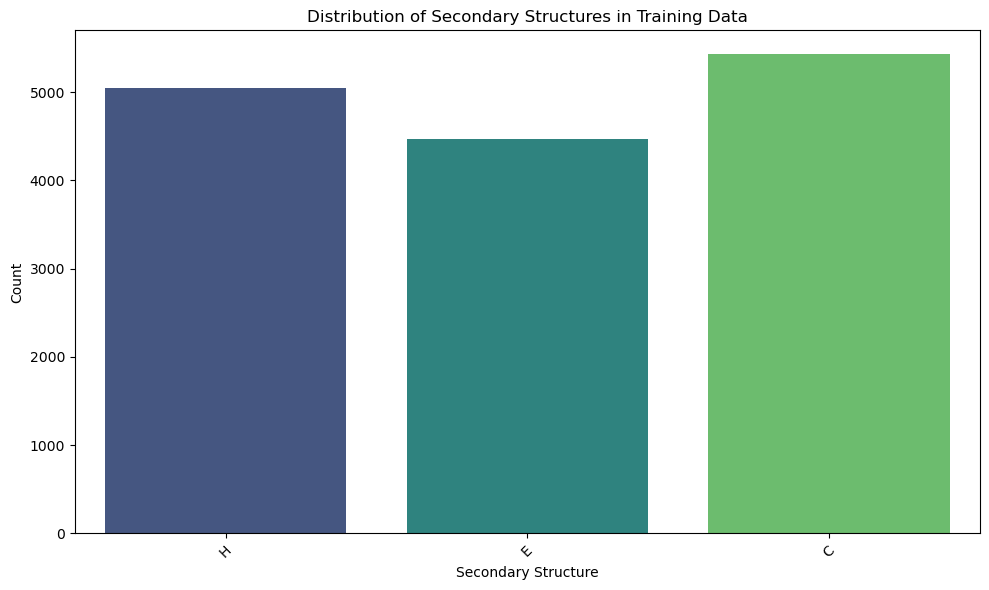

In [167]:
secstr_labels = [
    "H", "E", "C"
]

# Count how many sequences contain each secondary structure type
secstr_counts = {
    name: sum(i in secstr for secstr in train_df['Secondary Structure'])
    for i, name in enumerate(secstr_labels)
}

# Convert to DataFrame for plotting
secstr_df = pd.DataFrame.from_dict(secstr_counts, orient='index', columns=['Count']).reset_index()
secstr_df.rename(columns={'index': 'Secondary Structure'}, inplace=True)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Secondary Structure', y='Count', data=secstr_df, palette='viridis', hue='Secondary Structure', dodge=False)
plt.xticks(rotation=45)
plt.title('Distribution of Secondary Structures in Training Data')
plt.xlabel('Secondary Structure')
plt.ylabel('Count')
plt.tight_layout()
# plt.savefig('secstr_distribution.png')
plt.show()


Making pytorch dataloaders with a batch size of 32.

In [168]:
BATCH_SIZE = 32

In [169]:
def pad_batch(DataLoaderBatch):
    """
    DataLoaderBatch should be a list of (sequence, target, length) tuples...
    Returns a padded tensor of sequences sorted from longest to shortest, 
    """
    batch_size = len(DataLoaderBatch)
    batch_split = list(zip(*DataLoaderBatch))

    ids, seqs, pssms, lengths, secstrs, secstrs_q3 = batch_split[0], batch_split[1], batch_split[2] ,batch_split[3], batch_split[4], batch_split[5]
    max_length = max(lengths)

    padded_seqs = np.zeros((max_length, batch_size))
    padded_pssms = np.zeros((max_length,batch_size,22))
    padded_secstrs = np.ones((max_length,batch_size))*30
    padded_secstrs_q3 = np.ones((max_length,batch_size))*30
    
    for i, l in enumerate(lengths):
        padded_seqs[:l,i] = seqs[i][:l] + 1
        padded_pssms[:l,i,:] = pssms[i][:l][:]
        padded_secstrs[:l,i] = secstrs[i][:l]
        padded_secstrs_q3[:l,i] = secstrs_q3[i][:l]
    return torch.tensor(padded_seqs).type(torch.LongTensor), torch.tensor(padded_pssms).type(torch.float), torch.tensor(lengths), torch.tensor(padded_secstrs).type(torch.LongTensor), torch.tensor(padded_secstrs_q3).type(torch.LongTensor)

train_gen = data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_batch)
val_gen = data.DataLoader(val, batch_size=BATCH_SIZE,shuffle=False,collate_fn=pad_batch)
test_gen = data.DataLoader(test, batch_size=BATCH_SIZE,shuffle=False,collate_fn=pad_batch)

## Defining the hyperparameters model architectures, loss criterion and optimizer

In [170]:
LEARNING_RATE = 0.001 
EPOCHS = 100
DROPOUT = 0.2
HIDDEN_SIZE = 128
EMBEDDING_SIZE = 128
NUM_LAYERS =1 # Number of layers in the RNN
PATIENCE = 10 # Early stopping patience
MIN_DELTA = 0.001 # Minimum change in validation acc to qualify as an improvement

### Defining different layers of the model

Dense Layer:

In [171]:
class Dense(nn.Module):
    def __init__(self,input_dim,output_dim,dropout = DROPOUT,normalization = True,activation = F.relu):
        super(Dense, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.dropout_rate = dropout
        self.activation = activation
        self.n_state = normalization        
        self.linear = nn.Linear(self.input_dim,self.output_dim)
        self.layernorm = nn.LayerNorm(self.output_dim)
        self.dropout = nn.Dropout(p=self.dropout_rate)
        
    def forward(self, x):
        x = self.linear(x)
        x = self.activation(x)
        if self.n_state:
            x = self.layernorm(x)
        x = self.dropout(x)
        return x

Unidirectional RNN layer:

In [172]:
class rnn_unidirectional(nn.Module):
    def __init__(self,inp,out,dropout=DROPOUT,activation=F.relu):
        super(rnn_unidirectional,self).__init__()
        self.rnn = nn.RNN(inp,out,bidirectional=False,num_layers=NUM_LAYERS)
        self.dropout_rate = dropout
        self.layernorm = nn.LayerNorm(out)
        self.activation = activation
        self.input_dim = inp
        self.output_dim = out
        self.dropout = nn.Dropout(p=self.dropout_rate)

    def forward(self,x,lengths):
        x_ = pack_padded_sequence(x,lengths,enforce_sorted=False)
        out,_ = self.rnn(x_)
        out,_ = pad_packed_sequence(out)
        out = self.activation(out)
        out = self.layernorm(out)
        if self.input_dim == 2*self.output_dim:
            out = out+x
        out = self.dropout(out)
        return out

Bidirectional RNN layer

In [173]:
# Bidirectional RNN
class rnn_bidirectional(nn.Module):
    def __init__(self,inp,out,dropout=DROPOUT,activation=F.relu):
        super(rnn_bidirectional,self).__init__()
        self.rnn = nn.RNN(inp,out,bidirectional=True,num_layers=NUM_LAYERS)
        self.dropout_rate = dropout
        self.layernorm = nn.LayerNorm(2*out)
        self.activation = activation
        self.input_dim = inp
        self.output_dim = out
        self.dropout = nn.Dropout(p=self.dropout_rate)

    def forward(self,x,lengths):
        x_ = pack_padded_sequence(x,lengths,enforce_sorted=False)
        out,_ = self.rnn(x_)
        out,_ = pad_packed_sequence(out)
        out = self.activation(out)
        out = self.layernorm(out)
        if self.input_dim == 2*self.output_dim:
            out = out+x
        out = self.dropout(out)
        return out

Bidirectional GRU layer

In [174]:
# Bidirectional GRU
class gru_bidirectional(nn.Module):
    def __init__(self,inp,out,dropout=0.1,activation=F.relu):
        super(gru_bidirectional,self).__init__()
        self.gru = nn.GRU(inp,out,bidirectional=True,num_layers=2)
        self.dropout_rate = dropout
        self.layernorm = nn.LayerNorm(2*out)
        self.activation = activation
        self.input_dim = inp
        self.output_dim = out
        self.dropout = nn.Dropout(p=self.dropout_rate)

    def forward(self,x,lengths):
        x_ = pack_padded_sequence(x,lengths,enforce_sorted=False) #as we padded our sequences while batching,this undos the padding
        out,_ = self.gru(x_)
        out,_ = pad_packed_sequence(out)
        out = self.activation(out)
        out = self.layernorm(out)
        if self.input_dim == 2*self.output_dim:
            out = out+x
        out = self.dropout(out)
        return out

### Defining a general model architecture

In [175]:
class GeneralModel(nn.Module):
    def __init__(self, embedding_count=23, embedding_dim=50, output_dim=3, model_type='unidirectional_rnn'):
        super(GeneralModel,self).__init__()

        self.embedding = nn.Embedding(embedding_count, embedding_dim=embedding_dim, padding_idx=0)
        self.layernorm = nn.LayerNorm(22+embedding_dim)

        if model_type == 'unidirectional_rnn':
            self.l1 = rnn_unidirectional(embedding_dim+22, 128, 0.2)
            self.l2 = Dense(128, 64)
            self.l3 = Dense(64, output_dim, dropout=0.0)
            
        elif model_type == 'bidirectional_rnn':
            self.l1 = rnn_bidirectional(embedding_dim+22, 64, 0.2)
            self.l2 = Dense(128, 64)
            self.l3 = Dense(64, output_dim, dropout=0.0)
        
        elif model_type == 'bidirectional_gru':
            self.l1 = gru_bidirectional(embedding_dim+22, 64, 0.2)
            self.l2 = Dense(128, 64)
            self.l3 = Dense(64, output_dim, dropout=0.0)
        
    def forward(self, x, pssm, x_lengths):
        x = self.embedding(x)
        x = torch.cat((x, pssm), dim=-1)
        x = self.layernorm(x)
        x = self.l1(x, x_lengths)
        x = self.l2(x)
        x = self.l3(x)
        return x

## Training and Evaluation Scripts for the model

Helper function to train one epoch

In [ ]:
def train_one_epoch(generator, network, criterion, optimizer, task="Q3"):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    network.train()
    total_loss = 0.
    preds = []
    ground_truths = []
    
    # Unpacking order: seq, pssm, length, q8, q3
    for seq, pssm, length, q8, q3 in tqdm.tqdm(generator, desc="Training"):
        
        seq = seq.to(device)
        pssm = pssm.to(device)
        
        length = length.view(-1).cpu()
        
        optimizer.zero_grad()
        output = network(seq, pssm, length)
        
        # Targets are (MaxLen, Batch). Move to device.
        if task == "Q8":
            loss = criterion(output.view(-1, 8).to(device), q8.view(-1).to(device))
        else:
            loss = criterion(output.view(-1, 3).to(device), q3.view(-1).to(device))
            
        loss.backward()
        torch.nn.utils.clip_grad_norm_(network.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()

        for i in range(len(length)):
            l = int(length[i])
            # Prediction for i-th sequence: output[:l, i, :] -> (l, OutDim)
            p = torch.argmax(output[:l, i, :], dim=-1).cpu().numpy().tolist()
            preds.extend(p)
            
            if task == "Q8":
                ground_truths.append(q8[:l, i].cpu().numpy())
            else:
                ground_truths.append(q3[:l, i].cpu().numpy())
                
    g_ts = np.concatenate(ground_truths).flatten()
    avg_loss = total_loss / len(generator)
    accuracy = accuracy_score(g_ts, preds)
    
    return avg_loss, accuracy, g_ts, preds

Helper function to evaluate one epoch

In [177]:
def evaluate(generator, network, criterion, task="Q3"):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    network.eval()
    total_loss = 0.
    preds = []
    ground_truths = []
    
    with torch.no_grad():
        for seq, pssm, length, q8, q3 in tqdm.tqdm(generator, desc="Validation"):
            
            seq = seq.to(device)
            pssm = pssm.to(device)
            length = length.view(-1).cpu()

            output = network(seq, pssm, length)

            if task == "Q8":
                loss = criterion(output.view(-1, 8).to(device), q8.view(-1).to(device))
            else:
                loss = criterion(output.view(-1, 3).to(device), q3.view(-1).to(device))

            total_loss += loss.item()
            
            for i in range(len(length)):
                l = int(length[i])
                p = torch.argmax(output[:l, i, :], dim=-1).cpu().numpy().tolist()
                preds.extend(p)
                
                if task == "Q8":
                    ground_truths.append(q8[:l, i].cpu().numpy())
                else:
                    ground_truths.append(q3[:l, i].cpu().numpy())

    g_ts = np.concatenate(ground_truths).flatten()
    avg_loss = total_loss / len(generator)
    accuracy = accuracy_score(g_ts, preds)
    
    return avg_loss, accuracy, g_ts, preds

In [178]:
def train_model(network, train_gen, val_gen, criterion, optimizer, num_epochs=10, learning_rate=0.001, patience=5, min_delta=0.001, task="Q3"):
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    best_val_acc = 0
    epochs_wo_improve = 0
    best_epoch = 0

    for i in range(num_epochs):
        # Using the updated train_one_epoch
        train_loss, train_acc, _, _ = train_one_epoch(train_gen, network, criterion, optimizer, task=task)
        # Using the updated evaluate_model
        val_loss, val_acc, _, _ = evaluate(val_gen, network, criterion, task=task)

        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        if val_acc - best_val_acc > min_delta:
            best_val_acc = val_acc
            epochs_wo_improve = 0
            best_epoch = i
        else:
            epochs_wo_improve += 1

        if epochs_wo_improve >= patience:
            print(f'Early stopping at epoch {i+1}')
            break
        
        print(f'Epoch {i+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    return train_acc_history, val_acc_history, train_loss_history, val_loss_history

In [179]:
def plot_training_results(train_acc_history, val_acc_history, train_loss_history, val_loss_history):
    epochs = range(1, len(train_acc_history) + 1)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracies
    axes[0].plot(epochs, train_acc_history, 'b-', label='Train Accuracy', marker='o', markersize=4)
    axes[0].plot(epochs, val_acc_history, 'r-', label='Validation Accuracy', marker='s', markersize=4)
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim([0, 1])
    
    # Plot losses
    axes[1].plot(epochs, train_loss_history, 'b-', label='Train Loss', marker='o', markersize=4)
    axes[1].plot(epochs, val_loss_history, 'r-', label='Validation Loss', marker='s', markersize=4)
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

Function to evaluate the model

In [187]:
def evaluate_model(model, test_generator, criterion, task="Q3"):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    if task == "Q8":
        class_names = list(range(8))
    else:
        class_names = ["H", "E", "C"]
    
    model.eval()

    with torch.no_grad():
        total_loss = 0.
        preds = [] # Output predictions (indices)
        ground_truths = [] # Ground truth labels

        # Unpacking matches the pad_batch function: seq, pssm, length, q8, q3
        for seq, pssm, length, q8, q3 in tqdm.tqdm(test_generator, desc="Testing"):
            
            # Move inputs to device
            seq = seq.to(device)
            pssm = pssm.to(device)
            
            # Ensure length is a 1D tensor on CPU for pack_padded_sequence stability
            length = length.view(-1).cpu()

            # Forward pass
            output = model(seq, pssm, length) 

            # Calculate Loss
            if task == "Q8":
                loss = criterion(output.view(-1, 8).to(device), q8.view(-1).to(device))
            else:
                loss = criterion(output.view(-1, 3).to(device), q3.view(-1).to(device))
            
            total_loss += loss.item()
            
            # Collect predictions and ground truths sequence by sequence
            for i in range(len(length)):
                l = int(length[i])
                
                # Get predictions: output is (MaxLen, Batch, Classes)
                # Slice to valid length [:l], select i-th batch [i], all classes [:]
                p = torch.argmax(output[:l, i, :], dim=-1).cpu().numpy().tolist()
                preds.extend(p)
                
                # Get ground truths: q8/q3 is (MaxLen, Batch)
                if task == "Q8":
                    ground_truths.append(q8[:l, i].cpu().numpy())
                else:
                    ground_truths.append(q3[:l, i].cpu().numpy())
        
        # Calculate metrics
        avg_loss = total_loss / len(test_generator)
        g_ts = np.concatenate(ground_truths).flatten()
        
        # preds is already a list of integers, so use it directly
        accuracy = accuracy_score(g_ts, preds)

        print(f"Average Loss: {avg_loss:.4f}")
        print(f"Accuracy: {accuracy:.4f}")
        print("Classification Report:")
        print(classification_report(g_ts, preds, target_names=[str(c) for c in class_names]))

        # Confusion Matrix
        cm = confusion_matrix(g_ts, preds)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

In [181]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GeneralModel(embedding_count=23, embedding_dim=EMBEDDING_SIZE, output_dim=3, model_type='bidirectional_gru').to(device)
criterion = nn.CrossEntropyLoss(ignore_index=30)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
train_acc_history, val_acc_history, train_loss_history, val_loss_history = train_model(
    model, train_gen, val_gen, criterion, optimizer, num_epochs=EPOCHS, learning_rate=LEARNING_RATE, patience=PATIENCE, min_delta=MIN_DELTA, task="Q3"
)

Training:   0%|          | 0/170 [00:00<?, ?it/s]

Validation: 100%|██████████| 8/8 [00:00<00:00, 40.80it/s]


Epoch 1/100, Train Loss: 1.0136, Train Acc: 0.5236, Val Loss: 0.9769, Val Acc: 0.5808


Validation: 100%|██████████| 8/8 [00:00<00:00, 39.74it/s]


Epoch 2/100, Train Loss: 0.9273, Train Acc: 0.6176, Val Loss: 0.9109, Val Acc: 0.6346


Validation: 100%|██████████| 8/8 [00:00<00:00, 41.33it/s]


Epoch 3/100, Train Loss: 0.8750, Train Acc: 0.6520, Val Loss: 0.8433, Val Acc: 0.6758


Validation: 100%|██████████| 8/8 [00:00<00:00, 39.86it/s]


Epoch 4/100, Train Loss: 0.8157, Train Acc: 0.6927, Val Loss: 0.7773, Val Acc: 0.7137


Validation: 100%|██████████| 8/8 [00:00<00:00, 38.76it/s]


Epoch 5/100, Train Loss: 0.6876, Train Acc: 0.7420, Val Loss: 0.6096, Val Acc: 0.7752


Validation: 100%|██████████| 8/8 [00:00<00:00, 39.25it/s]


Epoch 6/100, Train Loss: 0.5996, Train Acc: 0.7752, Val Loss: 0.5688, Val Acc: 0.7932


Validation: 100%|██████████| 8/8 [00:00<00:00, 41.38it/s]


Epoch 7/100, Train Loss: 0.5767, Train Acc: 0.7830, Val Loss: 0.5542, Val Acc: 0.7917


Validation: 100%|██████████| 8/8 [00:00<00:00, 41.63it/s]


Epoch 8/100, Train Loss: 0.5455, Train Acc: 0.7943, Val Loss: 0.5257, Val Acc: 0.8073


Validation: 100%|██████████| 8/8 [00:00<00:00, 41.37it/s]


Epoch 9/100, Train Loss: 0.5065, Train Acc: 0.8070, Val Loss: 0.4927, Val Acc: 0.8161


Validation: 100%|██████████| 8/8 [00:00<00:00, 40.68it/s]


Epoch 10/100, Train Loss: 0.4753, Train Acc: 0.8181, Val Loss: 0.4613, Val Acc: 0.8245


Validation: 100%|██████████| 8/8 [00:00<00:00, 41.17it/s]


Epoch 11/100, Train Loss: 0.4564, Train Acc: 0.8240, Val Loss: 0.4434, Val Acc: 0.8322


Validation: 100%|██████████| 8/8 [00:00<00:00, 41.30it/s]


Epoch 12/100, Train Loss: 0.4426, Train Acc: 0.8287, Val Loss: 0.4446, Val Acc: 0.8300


Validation: 100%|██████████| 8/8 [00:00<00:00, 40.87it/s]


Epoch 13/100, Train Loss: 0.4351, Train Acc: 0.8319, Val Loss: 0.4409, Val Acc: 0.8324


Validation: 100%|██████████| 8/8 [00:00<00:00, 41.30it/s]


Epoch 14/100, Train Loss: 0.4256, Train Acc: 0.8346, Val Loss: 0.4279, Val Acc: 0.8380


Validation: 100%|██████████| 8/8 [00:00<00:00, 41.01it/s]


Epoch 15/100, Train Loss: 0.4196, Train Acc: 0.8370, Val Loss: 0.4327, Val Acc: 0.8357


Validation: 100%|██████████| 8/8 [00:00<00:00, 42.01it/s]


Epoch 16/100, Train Loss: 0.4130, Train Acc: 0.8394, Val Loss: 0.4216, Val Acc: 0.8392


Validation: 100%|██████████| 8/8 [00:00<00:00, 41.69it/s]


Epoch 17/100, Train Loss: 0.4069, Train Acc: 0.8417, Val Loss: 0.4232, Val Acc: 0.8410


Validation: 100%|██████████| 8/8 [00:00<00:00, 41.54it/s]


Epoch 18/100, Train Loss: 0.4007, Train Acc: 0.8438, Val Loss: 0.4170, Val Acc: 0.8420


Validation: 100%|██████████| 8/8 [00:00<00:00, 41.40it/s]


Epoch 19/100, Train Loss: 0.3953, Train Acc: 0.8457, Val Loss: 0.4107, Val Acc: 0.8436


Validation: 100%|██████████| 8/8 [00:00<00:00, 39.05it/s]


Epoch 20/100, Train Loss: 0.3930, Train Acc: 0.8465, Val Loss: 0.4103, Val Acc: 0.8441


Validation: 100%|██████████| 8/8 [00:00<00:00, 39.70it/s]


Epoch 21/100, Train Loss: 0.3884, Train Acc: 0.8479, Val Loss: 0.4067, Val Acc: 0.8455


Validation: 100%|██████████| 8/8 [00:00<00:00, 39.41it/s]


Epoch 22/100, Train Loss: 0.3821, Train Acc: 0.8501, Val Loss: 0.4111, Val Acc: 0.8441


Validation: 100%|██████████| 8/8 [00:00<00:00, 39.61it/s]


Epoch 23/100, Train Loss: 0.3795, Train Acc: 0.8511, Val Loss: 0.4143, Val Acc: 0.8460


Validation: 100%|██████████| 8/8 [00:00<00:00, 39.47it/s]


Epoch 24/100, Train Loss: 0.3750, Train Acc: 0.8526, Val Loss: 0.4035, Val Acc: 0.8474


Validation: 100%|██████████| 8/8 [00:00<00:00, 39.71it/s]


Epoch 25/100, Train Loss: 0.3703, Train Acc: 0.8538, Val Loss: 0.4058, Val Acc: 0.8463


Validation: 100%|██████████| 8/8 [00:00<00:00, 39.89it/s]


Epoch 26/100, Train Loss: 0.3679, Train Acc: 0.8552, Val Loss: 0.4007, Val Acc: 0.8479


Validation: 100%|██████████| 8/8 [00:00<00:00, 37.91it/s]


Epoch 27/100, Train Loss: 0.3654, Train Acc: 0.8563, Val Loss: 0.3960, Val Acc: 0.8485


Validation: 100%|██████████| 8/8 [00:00<00:00, 39.91it/s]


Epoch 28/100, Train Loss: 0.3618, Train Acc: 0.8575, Val Loss: 0.4031, Val Acc: 0.8487


Validation: 100%|██████████| 8/8 [00:00<00:00, 40.20it/s]


Epoch 29/100, Train Loss: 0.3575, Train Acc: 0.8589, Val Loss: 0.3941, Val Acc: 0.8501


Validation: 100%|██████████| 8/8 [00:00<00:00, 39.27it/s]


Epoch 30/100, Train Loss: 0.3541, Train Acc: 0.8600, Val Loss: 0.3991, Val Acc: 0.8478


Validation: 100%|██████████| 8/8 [00:00<00:00, 39.81it/s]


Epoch 31/100, Train Loss: 0.3512, Train Acc: 0.8616, Val Loss: 0.3998, Val Acc: 0.8479


Validation: 100%|██████████| 8/8 [00:00<00:00, 39.71it/s]


Epoch 32/100, Train Loss: 0.3477, Train Acc: 0.8628, Val Loss: 0.4053, Val Acc: 0.8458


Validation: 100%|██████████| 8/8 [00:00<00:00, 37.74it/s]


Epoch 33/100, Train Loss: 0.3439, Train Acc: 0.8642, Val Loss: 0.3953, Val Acc: 0.8493


Validation: 100%|██████████| 8/8 [00:00<00:00, 39.88it/s]


Epoch 34/100, Train Loss: 0.3436, Train Acc: 0.8641, Val Loss: 0.4038, Val Acc: 0.8483


Validation: 100%|██████████| 8/8 [00:00<00:00, 38.86it/s]


Epoch 35/100, Train Loss: 0.3391, Train Acc: 0.8660, Val Loss: 0.4022, Val Acc: 0.8498


Validation: 100%|██████████| 8/8 [00:00<00:00, 39.39it/s]


Epoch 36/100, Train Loss: 0.3351, Train Acc: 0.8674, Val Loss: 0.4015, Val Acc: 0.8495


Validation: 100%|██████████| 8/8 [00:00<00:00, 39.90it/s]


Epoch 37/100, Train Loss: 0.3337, Train Acc: 0.8679, Val Loss: 0.3975, Val Acc: 0.8496


Validation: 100%|██████████| 8/8 [00:00<00:00, 39.23it/s]


Epoch 38/100, Train Loss: 0.3308, Train Acc: 0.8691, Val Loss: 0.4022, Val Acc: 0.8472


Validation: 100%|██████████| 8/8 [00:00<00:00, 39.58it/s]

Early stopping at epoch 39


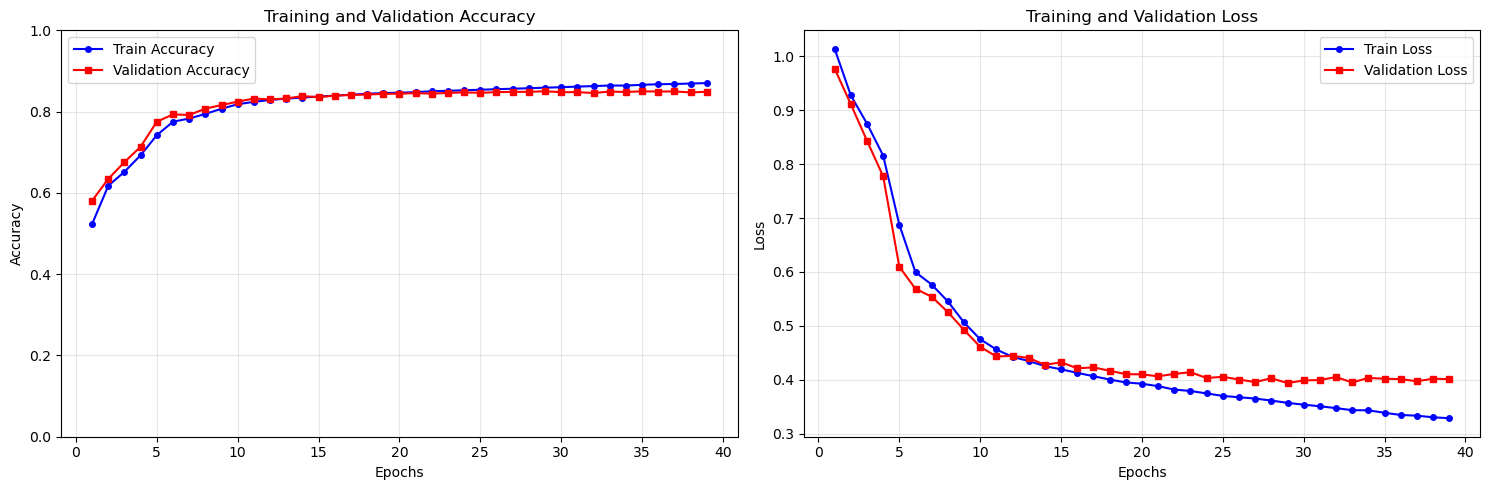

Testing: 100%|██████████| 9/9 [00:00<00:00, 30.92it/s]


Average Loss: 0.4197
Accuracy: 0.8407
Classification Report:
              precision    recall  f1-score   support

           H       0.90      0.88      0.89     19553
           E       0.84      0.73      0.78     11847
           C       0.80      0.86      0.83     23544

    accuracy                           0.84     54944
   macro avg       0.84      0.82      0.83     54944
weighted avg       0.84      0.84      0.84     54944



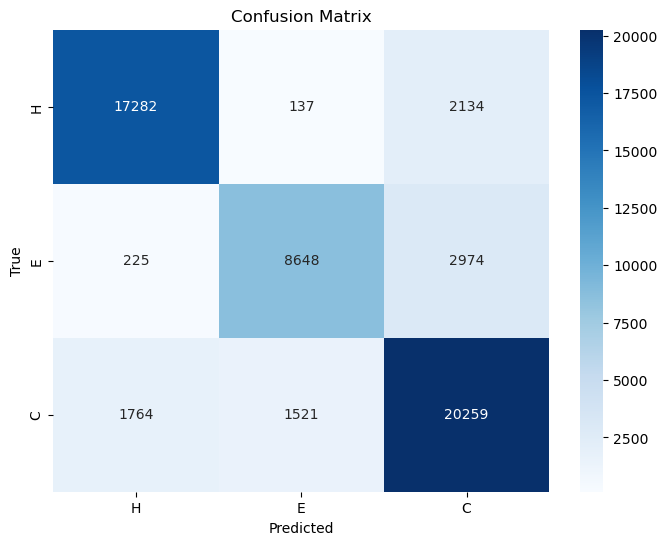

In [188]:
plot_training_results(train_acc_history, val_acc_history, train_loss_history, val_loss_history)

results = evaluate_model(model, test_gen, criterion, task="Q3")